In [1]:
# !pip install scipy statsmodels

In [1]:
import numpy as np
import scipy.optimize as opt
import scipy
import time
import statsmodels.api as sm
import pandas as pd 
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Suppress FutureWarnings

np.set_printoptions(suppress=True)
np.random.seed(44042)

---- 

# Replicating Arcidiacono Miller (2011), Table 1 Column (5)

In this case, the time-invariant type (bus model, say) is unobserved _but_ accounted for in estimation via the EM algorithm.

In [2]:
# Parameter values
alpha = np.array([2, -0.15, 1, 0.9, 0.4]) # θ_0, θ_1, θ_2, β, Pr(s = 0)

T = 20    # Time periods
N = 1000  # Number of individuals
burnin = 10

Grids for mileage (time-varying characteristic) and route characteristic (time-invariant).

In [3]:
# mileage 
x1 = np.arange(0, 25.125, 0.125)
x1l = len(x1)
# route char
x2 = np.arange(0.25, 1.26, 0.01)
x2l = len(x2)
# discrete type
x3 = np.arange(0, 2, 1)
x3l = len(x3)

### State Space Transition Probabilities

From Equation 7.2 (p. 1852), 
$$
f_2(x_{1, t+1} | x_{t}) = 1\{x_{1, t+1} \geq x_{t}\} [ e^{-x_2(x_{1, t+1} - x_{t})} - e^{-x_2(0.125 + x_{1, t+1} - x_{t})} ]
$$
Note $f_1(x_{1, t+1} | x_{t}) = f_1(x_{1, t+1} | 0)$. Rows are $x_t$ and columns are $x_{t+1}$.

In [4]:
def xgrid(x1, x2, x1l, x2l):
    x1ub = np.concatenate([x1[1:], [np.inf]])
    xtran = np.zeros((x1l * x2l, x1l))  # Placeholder for transition matrix
    xtranc = np.zeros((x1l, x1l, x2l))  # Placeholder for cumulative transition matrix
    xtran_slice = np.zeros((x1l, x1l))
    for j in range(x2l):
        for i in range(x1l):
            xtran_slice[:, i] = (x1[i] >= x1) * ( np.exp(- x2[j] * (x1[i] - x1)) - np.exp(- x2[j] * (x1ub[i] - x1)) )
        xtran[x1l * j : x1l * (j + 1), :] = xtran_slice / xtran_slice.sum(axis = 1, keepdims=True)
        xtranc[:, :, j] = np.clip(np.cumsum(xtran_slice, axis = 1), 0.0, 1.0)
    return xtran, xtranc

xtran, xtranc = xgrid(x1, x2, x1l, x2l)
xtran[:4, :4]

array([[0.03076677, 0.02982017, 0.0289027 , 0.02801346],
       [0.        , 0.03076677, 0.02982017, 0.0289027 ],
       [0.        , 0.        , 0.03076677, 0.02982017],
       [0.        , 0.        , 0.        , 0.03076677]])

### Simulate Engine Replacement Data (```genbus4.m```)

$$
u_1(x_{1t}, s) = 0 \quad\quad\quad\quad u_2(x_{1t}, s) = \theta_0 + \theta_1 \min\{x_{1t}, 25\} + \theta_2 s
$$

In [5]:
def flowpayoff_replace(alpha, x1, x3): 
    return 0.0

def flowpayoff_noreplace(alpha, x1, x3): 
    return alpha[0] + alpha[1] * x1 + alpha[2] * x3

Define the choice-specific conditional value function, $v_{jt}(z_t)$, as the flow payoff of action $j$ without $\varepsilon_{jt}$ plus the expected future utility conditional on following the optimal decision rule from period t + 1 on:
$$
v_{jt}(z_t) = u_{jt}(z_t) + \beta \sum_{z_{t+1}} V_{t+1}(z_{t+1}) f_{jt}(z_{t+1} | z_{t})
$$
where $V_{t+1}(z_{t+1}) = \int_{\varepsilon_{t+1}} \max\{v_{1t+1}(z_t+1), v_{2t+1}(z_t+1)\} dF(\varepsilon_{t+1})$. Assuming $\varepsilon_{t+1} \sim EVT1$ i.i.d. across choices and over time, 
$$
V_{t+1}(z_{t+1}) = \int_{\varepsilon_{t+1}} \max\{v_{1t+1}(z_t+1) + \varepsilon_{1t+1}, v_{2t+1}(z_t+1)  + \varepsilon_{2t+1}\} dF(\varepsilon_{t+1}) = \gamma_{Euler} + \ln \bigg( e^{v_{1t+1}(z_t+1)} + e^{v_{2t+1}(z_t+1)} \bigg)
$$
See Equation 2.4 and Equation 14 in [Llull's notes](https://joanllull.github.io/Structural_micro/Structural_micro_3.pdf). 

In [6]:
def conditional_value_function(beta, u_zt, V_ztprime, f_ztprime_zt):
    return u_zt + beta * np.dot(f_ztprime_zt, V_ztprime)

def Emax(v_replace, v_noreplace):
    return np.euler_gamma + np.logaddexp( v_replace, v_noreplace )

Recall $v_{jt}(z_t)$ always takes the standpoint of being at time $t$ _just before_ $\varepsilon$ is realized. 

If you take the renewal action this period, you go back to zero and hence the relevant transition to the future is $f_t(x_{t+1} | 0)$. 

If you do not take the renewal action, the relevant transition depends on your accumulated mileage, $f_t(x_{t+1} | x_t)$.

In [7]:
def BackwardInduction_V(alpha, x1, x2, x3, x1l, x2l, x3l, TT):
    V = np.zeros((x1l * x2l, 2, TT + 1)) 
    for t in range(TT - 1, 0, -1):
        for x3idx in range(x3l):
            for x2idx in range(x2l):
                for x1idx in range(x1l): # indexing x_{1t} as we enter the period 
                    v_replace   = conditional_value_function(alpha[3], flowpayoff_replace(alpha, x1[x1idx], x3[x3idx]),   V[x1l * x2idx : x1l * (x2idx + 1), x3[x3idx], t + 1], xtran[x1l * x2idx, :])
                    v_noreplace = conditional_value_function(alpha[3], flowpayoff_noreplace(alpha, x1[x1idx], x3[x3idx]), V[x1l * x2idx : x1l * (x2idx + 1), x3[x3idx], t + 1], xtran[x1l * x2idx + x1idx, :])
                    V[x1l * x2idx + x1idx, x3[x3idx], t] = Emax(v_replace, v_noreplace)
    return V 

In [8]:
def genbus(alpha, N, T, burnin, xtran, xtranc, x1, x2, x3, x1l, x2l, x3l):
    
    V = BackwardInduction_V(alpha, x1, x2, x3, x1l, x2l, x3l, T + burnin)

    x1idx = np.zeros((N, T + burnin + 1)).astype(int)
    x2idx = np.ceil( x2l * np.random.rand(N) - 1).astype(int)    # ensure rng stream consistency with matlab, not preserved by randint()
    x3idx  = (np.random.rand(N) > alpha[4]).astype(int)          # type
    Y = np.zeros((N, T + burnin + 1))
    X1 = np.zeros((N, T + burnin + 1))                           # accumulating mileage. all buses start at zero.  
    X2 = x2[x2idx]                                               # permanent characteristic
    p_replace = np.zeros((N, T + burnin + 1))
    Draw = np.random.rand(T + burnin, N).T                       # to ensure the same random draws as the matlab script are used (row-major vs column-major ^.^)
    Draw2 = np.random.rand(T + burnin, N).T

    for n in range(N):
        for t in range(T + burnin):
            v_replace   = conditional_value_function(alpha[3], flowpayoff_replace(alpha, X1[n, t], x3idx[n]), V[x2idx[n] * x1l : (x2idx[n] + 1) * x1l, x3idx[n], t + 1], xtran[x2idx[n] * x1l, :])
            v_noreplace = conditional_value_function(alpha[3], flowpayoff_noreplace(alpha, X1[n, t], x3idx[n]), V[x2idx[n] * x1l : (x2idx[n] + 1) * x1l, x3idx[n], t + 1], xtran[x2idx[n] * x1l + x1idx[n, t], :])
            p_replace[n, t] = 1 / ( 1 + np.exp(v_noreplace - v_replace) )
            Y[n, t] = Draw[n, t] < p_replace[n, t] # Y = 1 <-> replace.
            x1idx[n, t + 1] = (1 - Y[n, t]) * np.sum((Draw2[n, t] * np.ones(x1l)) > xtranc[x1idx[n, t], :, x2idx[n]]) # if not replace, draw x_{1t+1} from mileage transition; if replace, x_{1t+1} = 0.
            X1[n, t + 1] = x1[x1idx[n, t + 1]]

    # The econometrician is assumed to see only the last T periods. (p.1853)  
    return Y[:, burnin:T+burnin], X1[:, burnin:T+burnin], X2, x1idx[:, burnin:T+burnin], x2idx, x3idx

----
## CCP Estimator

The CCP estimator makes uses the Hotz Miller result that there exists a real-valued function $\psi_k[p_t(z_t)]$ for any (potentially sub-optimal) choice $k = 1, \dots, J$ such that
$$
\psi_k[p_t(z_t)] ≡ V_t(z_t) − v_{kt}(z_t)
$$
to rewrite the choice-specific conditional value function as (for an arbitrary $k$)
$$
v_{jt}(z_t) = u_{jt}(z_t) + \beta \sum_{z_{t+1}} \bigg[ \psi_k[p_{t+1}(z_{t+1})] + v_{kt+1}(z_{t+1})\bigg] f_{jt}(z_{t+1} | z_{t})
$$
Now consider the sequences {[renew at $t$, renew at $t+1$]; [not renew at $t$, renew at $t+1$]}. Intuitively, because renewing tomorrow leads to the same state in the two sequences, the choice-specific conditional value functions will be the same for both sequences in all periods from $t+2$ onwards. 
To make use of this fact, use the Hotz Miller result to replace $v_{kt+1}(z_{t+1})$ in the above:
$$
v_{jt}(z_t) = u_{jt}(z_t) + \beta \sum_{z_{t+1}} \big[ u_{kt+1}(z_{t+1}) + \psi_k[p_{t+1}(z_{t+1})] \big] f_{jt}(z_{t+1} | z_{t}) + \beta^2 \sum_{z_{t+1}} \sum_{z_{t+2}} \big[ \psi_{k^\prime}[p_{t+2}(z_{t+2})] + v_{{k^\prime}t+2}(z_{t+2}) \big] f_{jt+1}(z_{t+2} | z_{t+1}) f_{jt}(z_{t+1} | z_{t})
$$
The difference between any two paths that lead to taking the renewal action $k$ at $t+1$ is therefore 
$$
v_{jt}(z_t) - v_{j^\prime t}(z_t) = u_{jt}(z_t) - u_{j^\prime t}(z_t) + \beta \sum_{z_{t+1}} \big[ u_{kt+1}(z_{t+1}) + \psi_k[p_{t+1}(z_{t+1})] \big] \big[f_{jt}(z_{t+1} | z_{t}) - f_{j^\prime t}(z_{t+1} | z_{t}) \big]
$$ 
Notice that there is a **typo** in Equations 3.13 and 7.3 of the published version, which contain $- \psi_k$ instead of $+ \psi_k$. The correct formula appears in follow-up Arcidiacono Miller papers and [Llull's notes](https://joanllull.github.io/Structural_micro/Structural_micro_4.pdf) (see e.g. equation 15).

Let $j$ = not replace, $j^\prime$ = replace, and $k$ = replace. Then 
$$
v_{jt}(z_t) - v_{j^\prime t}(z_t) = u_{jt}(z_t) + \beta \sum_{z_{t+1}} \psi_{j^\prime}[p_{t+1}(z_{t+1})] \big[f_{jt}(z_{t+1} | z_{t}) - f_{j^\prime t}(z_{t+1} | z_{t}) \big]
$$ 

In the EM case, we _augment_ the data by constructing a column that contains the unobserved state. In this instance, because there are two possible unobserved states, this duplicates the data.

---- 

### Implementation

The simulation evidence in AM is based on the two-step estimator proposed in Section 6. 

In a first step one estimates the parameters governing state transitions and empirical choice probabilities. 
In a second step, one estimates the remaining parameters of the structural model holding first step estimates fixed. 

The estimator iterates between the two steps to convergence. 

In their simulation evidence AM assume the parameters governing state transitions have been estimated and they treat (observed) state transitions as known.


#### First Stage

As shown in equation 6.2, in the first stage p solves
$$
p^m = \arg\max_p \sum_i \sum_s \pi^m_{is} \sum_t \sum_j 1\{Y_{it} = j\} \times \ln p_{jt}(x_{it}, s)
$$
AM approximate $p_{jt}(x_{it}, s)$ as 
$$
p_{jt}(x_{it}, s) \approx \frac{e^{Z(x_{it}, t, s) \gamma_{j}}}{\sum_{j^\prime} e^{Z(x_{it}, t, s) \gamma_{j^\prime}}}
$$
where $Z(x_{it}, t, s)$ is a function of observed and unobserved state, as well as time. 
The optimization above reduces to weighted logistic regression of $Y_{it}$ (repeated for each $s$) on $Z(x_{it}, t, s)$. 

The next function computes $Z(x_{it}, t, s)$ for each observation (multiplied by $S$). 

In [11]:
def CCP_Z_observations(N, T, X1, X2, x3, x3l):

    x1_r = X1.T.reshape(N * T) / 10
    x1_r = np.vstack( [x1_r] * x3l ).flatten()
    x2_r = np.tile(X2, (1, T))
    x2_r = np.vstack( [x2_r.T] * x3l ).flatten()
    x3_r = np.repeat( x3, (N * T))
    t_r = np.repeat(np.arange(1, T + 1), N) / 10
    t_r = np.vstack( [t_r.T] * x3l ).flatten()
    
    xx = np.empty((x3l * N * T, 12))
    xx[:, 0]  = 1
    xx[:, 1]  = x1_r
    xx[:, 2]  = x2_r
    xx[:, 3]  = x1_r * x2_r
    xx[:, 4]  = x1_r ** 2
    xx[:, 5]  = x2_r ** 2
    xx[:, 6]  = x3_r
    xx[:, 7]  = x3_r * x1_r
    xx[:, 8]  = x3_r * x2_r
    xx[:, 9]  = x3_r * x1_r * x2_r
    xx[:, 10] = x3_r * x1_r ** 2
    xx[:, 11] = x3_r * x2_r ** 2

    xx = np.column_stack([
        xx,
        np.vstack( [t_r.T] * 12).T * xx,
        np.vstack( [t_r.T ** 2] * 12).T * xx
    ])

    return xx

The next function instead computes $Z(x_{it}, s, t)$ over the entire state space (augmented by time), which we use to compute fitted CCPs.

In [10]:
def CCP_Z_statespace(t, x1, x2, x3, x1l, x2l, x3l): 
    x1r = np.tile(x1, x2l) / 10
    x2r = np.repeat(x2, x1l)
    RX1 = np.column_stack([np.ones(x2l * x1l), x1r, x2r, x1r * x2r, x1r ** 2, x2r ** 2])
    return np.column_stack([RX1, x3 * RX1, (t / 10) * RX1, x3 * (t / 10) * RX1,  RX1 * (t / 10) ** 2, x3 * RX1 * (t / 10) ** 2])

Under the assumption that $\varepsilon \sim EVT1$, $\psi_k[p_{t+1}(z_{t+1})] = - \ln p_{kt+1}(z_{t+1})$:
$$
v_{jt}(z_t) - v_{j^\prime t}(z_t) = u_{jt}(z_t) - \beta \sum_{z_{t+1}}\ln p_{j^\prime t+1}(z_{t+1}) \big[f_{jt}(z_{t+1} | z_{t}) - f_{j^\prime t}(z_{t+1} | z_{t}) \big]
$$ 

The Supp Mat contains the formula for $\psi_k()$ under a nested logit assumption. 
Fosgerau et al. (2021) show how to more generally compute $\psi_k()$ when you observe $p$ and can simulate from $F(\varepsilon)$.

In [ ]:
def fvdata_EM(GAMMA, N, T, x1idx, x2idx, x3idx, x1, x2, x3, x1l, x2l, x3l, xtran):

    # Compute - ln[p_{1t+1}(x_{t+1}, s)] over the entire state space using estimated logit, which has Y = 1{Renew}
    psi_renew = np.zeros((x1l * x2l, x3l, T + 1))
    for t in range(1, T):
        for s in range(x3l):
            psi_renew[:, s, t] = np.log1p(np.exp(- CCP_Z_statespace(t+1, x1, x2, x3[s], x1l, x2l, x3l) @ GAMMA))

    # Compute \sum_s ln[p_{1t+1}(x_{t+1}, s)] [f_2(x_{t+1}|x_t) − f_1(x_{t+1}|x_t)] -- see Supp. Mat., p.12 
    Deltav = np.zeros((N, T, x3l))
    for n in range(N):
        for t in range(T):
            for s in range(x3l):
                Deltav[n, t, s] = np.dot(psi_renew[x1l * x2idx[n] : x1l * (x2idx[n] + 1), s, t + 1],  xtran[x1l * x2idx[n] + x1idx[n, t], :] - xtran[x1l * x2idx[n], :])

    return Deltav.reshape(N* T * x3l, 1, order = 'F'), psi_renew

Let 1 be the decision to renew and 0 the decision to keep. Then the likelihood contribution of an individual observation treating the unobserved state as observed is 
$$
Pr(Y_{it} = 1 | X_{it}, s_i; \theta) = 
\frac{\exp( v_{1t}(z_t) )}{\exp( v_{1 t}(z_t) ) + \exp( v_{0 t}(z_t) )} = 
\frac{1}{1 + \exp( v_{0 t}(z_t) - v_{1 t}(z_t))} =
\frac{1}{1 + e^{- u_{1t}(z_t) - \beta \sum_{z_{t+1}} \ln[p_{1t+1}(z_{t+1})] \big[f_{0t}(z_{t+1} | z_{t}) - f_{1 t}(z_{t+1} | z_{t}) \big] }}
\equiv Pr(Y_{it} = 1 | X_{it}, s_i; \theta, p)
$$
We do not observe $s_i$. Integrating out $s_i$, 
$$
Pr(\bm{Y}_{i} | \bm{X}_{i}; \theta, \pi, p) = \sum_{s} \pi(s | \bm{X}_{i}) \prod_t Pr(Y_{it} = 1 | X_{it}, s; \theta, p)
$$
We could now compute the maximum likelihood estimator as $\arg\max_{\pi, \theta} \sum_i \ln Pr(\bm{Y}_{i} | \bm{X}_{i}; \theta, \pi, p)$. 
Expectation Maximization simply consists in iterating between maximizing wrt $\pi$ and $\theta$.

Start with guesses $\pi^m, \theta^m, p_1^m$ at iteration $m$. Then by Bayes' rule 
$$
q_{i}(\theta, \pi, p) \equiv Pr(s_i = s | \bm{X}_{i}, \bm{Y}_{i}; \theta, \pi, p) = \frac{Pr(\bm{Y}_{i} | \bm{X}_{i}, s_i = s; \theta, p) Pr(s_i = s| \bm{X}_{i})}{\sum_{s^\prime} Pr(\bm{Y}_{i} | \bm{X}_{i}, s_i = s^\prime; \theta, p) Pr(s_i = s^\prime| \bm{X}_{i})} = \frac{Pr(\bm{Y}_{i} | \bm{X}_{i}, s; \theta, p) \pi( s | \bm{X}_{i})}{\sum_{s^\prime} Pr(\bm{Y}_{i} | \bm{X}_{i}, s^\prime; \theta, p) \pi( s^\prime | \bm{X}_{i})}
$$
This suggests Step 1, p.1831:
$$
q^{m+1}_{i}(s; \theta^m, \pi^m, p) = \frac{Pr(\bm{Y}_{i} | \bm{X}_{i}, s; \theta^m, p) \pi^{m}( s | \bm{X}_{i})}{\sum_{s^\prime} Pr(\bm{Y}_{i} | \bm{X}_{i}, s^\prime; \theta^m, p) \pi^{m}( s^\prime | \bm{X}_{i})}
$$
Next, note that 
$$
p_1(s, x) = Pr(Y_{it} = 1 | X_{it} = x, s_i = s)
= \frac{E ( 1\{Y_{it} = 1\} \times 1\{s_i = s\} | X_{it} = x) }{E(1\{s_i = s\} | X_{it} = x) }
= \frac{E [ 1\{Y_{it} = 1\} E ( 1\{s_i = s\} | \bm{Y}_{i}, \bm{X}_{i}) | X_{it} = x] }{E [ E ( 1\{s_i = s\} | \bm{Y}_{i}, \bm{X}_{i}) | X_{it} = x] }
= \frac{E [ 1\{Y_{it} = 1\} q_{i}(s) | X_{it} = x] }{E [ q_{i}(s) | X_{it} = x] }
$$
suggesting Step 3, p. 1832: 
$$
p^{m+1}_1(s, x) = \frac{ \sum_i \sum_t 1\{Y_{it} = 1\} q^{m+1}_{i}(s) }{ \sum_i \sum_t q^{m+1}_{i}(s) }
$$ 
We also use the fact that the unconditional probability of state $s$ is the integral over the conditional probabilities to form Step 2,  
$$
\pi^{m+1}( s; \theta^m, p ) = \frac{1}{N} \sum_i q^{m+1}_{i}(s; \theta^m, \pi^m, p)
$$
Note this step is different from the one implemented below, which instead is discussed in Supp Mat Section B.1.4.


These three steps make up the _expectation_ part of the EM algorithm. 
Step 4 is the _maximization_ part: with $q^{m+1}_{i}(s)$ and $p^{m+1}_1(s, x)$ in hand, we update $\theta^{m+1}$ as
$$
\arg \max_{\theta} \sum_i \sum_t \sum_{s} q^{m+1}_{i}(s) \ln Pr(Y_{it} = 1 | X_{it}, s; \theta, p^{m+1})
$$


Note that AM parameterize the probability of latent class as a flexible logit based on (observed) first period characteristics: 
$$
\pi(s_i = 1 | X_{i1}) = \frac{e^{X_{i1}\delta}}{1 + e^{X_{i1}\delta}}
$$
So that Step 2 is replaced with 
$$
\delta^{m+1} = \arg\max_\delta \sum_i \log \bigg( \sum_{s}  \pi(s_i | X_{i1}) \prod_t Pr(Y_{it} = 1 | X_{it}, s_i; \theta^m, p^m) \bigg)
$$



---- 

## Simulation and Estimation

In [ ]:
def X_initial_conditions(N, X1, X2):
    return np.column_stack([np.ones((N)), X1[:N, 0], X2])

def logl_initial_conditions(DELTA, Xinitcond, logl_is):
    Xb = Xinitcond @ DELTA
    logp_s1 = - np.logaddexp(0, -Xb)
    logp_s = np.column_stack([logp_s1, - Xb + logp_s1])
    summ = np.sum( np.exp(logp_s + logl_is), axis = 1)
    return - np.sum( np.log( summ / np.min(summ) ) + np.log(np.min(summ)) ) 

In [ ]:
def logPr_Update(b, Y, X):
    Xb = X @ b
    return (1 - Y) * Xb - np.logaddexp(0, Xb)

def step1_log(DELTA, Xinitcond, logl_is):
    Xb = Xinitcond @ DELTA
    logp_s1 = - np.logaddexp(0, -Xb)
    logp_s = np.column_stack([logp_s1, - Xb + logp_s1])
    summ = np.exp(logp_s + logl_is)
    return summ / summ.sum(axis = 1, keepdims=True)

In [15]:
def logl_logit_weighted(b, Y, X, w): 
    Xb = X @ b
    return np.sum( w * (np.logaddexp(0, -Xb) + (1 - Y) * Xb) )

Initialize the parameter vectors we are iterating over. We estimate logits that ignore unobserved heterogeneity to get starting values.

In [ ]:
Y, X1, X2, x1idx, x2idx, x3idx = genbus(alpha, N, T, burnin, xtran, xtranc, x1, x2, x3, x1l, x2l, x3l)

Xinitcond = X_initial_conditions(N, X1, X2)

yy = np.tile(Y.reshape(N * T, order = 'F'), x3l)
xx = CCP_Z_observations(N, T, X1, X2, x3, x3l)

logit_result = opt.minimize(logl_logit_weighted, np.zeros(xx.shape[1]), args = (yy, xx, 1))
logit_pars = logit_result.x

Deltav, psi_renew = fvdata_EM(logit_pars, N, T, x1idx, x2idx, x3idx, x1, x2, x3, x1l, x2l, x3l, xtran)
RHS_7_3 = np.column_stack([ np.ones(x3l * N * T), np.tile(X1.reshape(N * T, order = 'F'), x3l), np.repeat( x3, (N * T)), Deltav])

# structural parameters
ccp_result = opt.minimize(logl_logit_weighted, np.zeros(4), args = (yy, - RHS_7_3, 1))
ccp_pars = ccp_result.x

# delta (see Supp Mat B.1.4)
DELTA = np.zeros(3)

##### EM Iteration With Initial Conditions Fix

In [ ]:
cond = 0 
lp = []
iter = 0
max_iter = 1000
tol = 1e-7

while (cond == 0) & (iter < max_iter + 1):
    if (iter > 0): 
        print(f"Iteration {iter}/{max_iter} Estimated pi: {np.mean( q_NxS, axis = 0)}. Structural parameters: {ccp_pars}")

    # \sum_t log( l_{it} ) 
    logl_is = np.sum(logPr_Update(ccp_pars, yy, RHS_7_3).reshape(N, T, x3l, order = 'F'), axis = 1)

    # update parameters for \pi(s | x) [Step 2 with initial conditions]
    initcond_result = opt.minimize(logl_initial_conditions, np.zeros(3), args = (Xinitcond, logl_is))
    DELTA = initcond_result.x
    lp.append(initcond_result.fun)  
    
    q_NxS = step1_log(DELTA, Xinitcond, logl_is)
    q = np.vstack([q_NxS] * T).reshape(-1, 1, order = 'F').flatten()
    
    # Step 3
    logit_result = opt.minimize(logl_logit_weighted, logit_pars, args = (yy, xx, q))
    logit_pars = logit_result.x

    # update RHS that treats s as observed
    Deltav, psi_renew = fvdata_EM(logit_pars, N, T, x1idx, x2idx, x3idx, x1, x2, x3, x1l, x2l, x3l, xtran)
    RHS_7_3 = np.column_stack([np.ones(x3l * N * T), np.tile(X1.reshape(N * T, order = 'F'), x3l), np.repeat( x3, (N * T)), Deltav])

    # Step 4
    ccp_result = opt.minimize(logl_logit_weighted, ccp_pars, args = (yy, - RHS_7_3, q))
    ccp_pars = ccp_result.x
    
    # checking convergence 
    if iter > 26:
        junk  = np.abs((lp[iter] - lp[iter - 25]) / lp[iter]) < tol
        junk2 = np.abs((lp[iter-1] - lp[iter - 26]) / lp[iter - 1]) < tol
        cond = junk2 * junk
    iter += 1

Iteration 1/1000. Likelihood improvement: 0.0. Estimated pi: [0.49699756 0.50300244]. Structural parameters: [ 2.41762321 -0.14381959  0.00022313  0.86169888]
Iteration 2/1000. Likelihood improvement: 1.5348451276366027e-06. Estimated pi: [0.54532189 0.45467811]. Structural parameters: [ 2.38372542 -0.14619299  0.08774892  0.85479641]
Iteration 3/1000. Likelihood improvement: 0.0005110915609794934. Estimated pi: [0.58901604 0.41098396]. Structural parameters: [ 2.37054268 -0.14646276  0.13561802  0.85481016]
Iteration 4/1000. Likelihood improvement: 8.705645875355691e-05. Estimated pi: [0.58855237 0.41144763]. Structural parameters: [ 2.36718964 -0.14773344  0.14268675  0.84642505]
Iteration 5/1000. Likelihood improvement: 0.0002507846437598302. Estimated pi: [0.69613496 0.30386504]. Structural parameters: [ 2.37570228 -0.14796107  0.16395928  0.844862  ]
Iteration 6/1000. Likelihood improvement: 2.8957199790014137e-05. Estimated pi: [0.70164564 0.29835436]. Structural parameters: [ 2.

---- 

## Monte Carlo

In [ ]:
# starting values for FIML and CCP
Tccp  = []
Bccp  = []

for MC in range(50):
    
   Y, X1, X2, x1idx, x2idx, x3idx = genbus(alpha, N, T, burnin, xtran, xtranc, x1, x2, x3, x1l, x2l, x3l)

   ## CCP estimation
   time_start = time.time()

   Xinitcond = X_initial_conditions(N, X1, X2)

   yy = np.tile(Y.reshape(N * T, order = 'F'), x3l)
   xx = CCP_Z_observations(N, T, X1, X2, x3, x3l)

   logit_result = opt.minimize(logl_logit_weighted, np.zeros(xx.shape[1]), args = (yy, xx, 1))
   logit_pars = logit_result.x

   Deltav, psi_renew = fvdata_EM(logit_pars, N, T, x1idx, x2idx, x3idx, x1, x2, x3, x1l, x2l, x3l, xtran)
   RHS_7_3 = np.column_stack([ np.ones(x3l * N * T), np.tile(X1.reshape(N * T, order = 'F'), x3l), np.repeat( x3, (N * T)), Deltav])

   # structural parameters
   ccp_result = opt.minimize(logl_logit_weighted, np.zeros(4), args = (yy, - RHS_7_3, 1))
   ccp_pars = ccp_result.x
   ccp_pars[2] = .5 # nudge the effect of the unobserved state in the right direction 

   # delta (see Supp Mat B.1.4)
   DELTA = np.zeros(3)

   cond = 0 
   lp = []
   iter = 0
   max_iter = 1000
   tol = 1e-7

   while (cond == 0) & (iter < max_iter + 1):
      if (iter > 0) & (iter % 25 == 0): 
         print(f"MC {MC} / 50, Iteration {iter}/{max_iter}. Likelihood improvement: {np.abs((lp[iter - 1] - lp[iter - 2])) / lp[iter - 1]}." + 
               f" Estimated pi: {np.round(np.mean( q_NxS, axis = 0), 3)}. Structural parameters: {np.round(ccp_pars, 3)}")

      # \sum_t log( l_{it} ) 
      logl_is = np.sum(logPr_Update(ccp_pars, yy, RHS_7_3).reshape(N, T, x3l, order = 'F'), axis = 1)

      # update parameters for \pi(s | x) [Step 2 with initial conditions]
      initcond_result = opt.minimize(logl_initial_conditions, np.zeros(3), args = (Xinitcond, logl_is))
      DELTA = initcond_result.x
      lp.append(initcond_result.fun)  
      
      q_NxS = step1_log(DELTA, Xinitcond, logl_is)
      q = np.vstack([q_NxS] * T).reshape(-1, 1, order = 'F').flatten()

      # Step 3a
      logit_result = opt.minimize(logl_logit_weighted, logit_pars, args = (yy, xx, q))
      logit_pars = logit_result.x

      # update RHS that treats s as observed
      Deltav, psi_renew = fvdata_EM(logit_pars, N, T, x1idx, x2idx, x3idx, x1, x2, x3, x1l, x2l, x3l, xtran)
      RHS_7_3 = np.column_stack([np.ones(x3l * N * T), np.tile(X1.reshape(N * T, order = 'F'), x3l), np.repeat( x3, (N * T)), Deltav])

      # Step 4
      ccp_result = opt.minimize(logl_logit_weighted, ccp_pars, args = (yy, - RHS_7_3, q))
      ccp_pars = ccp_result.x
      
      # the convergence check in AM is based on the likelihood of the initial conditions model. 
      if iter > 26:
         junk  = np.abs((lp[iter] - lp[iter - 25]) / lp[iter]) < tol
         junk2 = np.abs((lp[iter-1] - lp[iter - 26]) / lp[iter - 1]) < tol
         cond = junk2 * junk
      iter += 1

   time_taken = time.time() - time_start
   Tccp.append(time_taken)
   Bccp.append(ccp_pars)
   print(f"MC {MC} / 50. CCP Time taken: {np.round(time_taken, 2)} seconds. CCP Optimized parameters: {np.round(ccp_pars, 3)}. True parameters: {alpha[:4]}")

MC 0 / 50, Iteration 25/1000. Likelihood improvement: 1.075422549750282e-06. Estimated pi: [0.628 0.372]. Structural parameters: [ 2.154 -0.157  1.171  0.887]
MC 0 / 50, Iteration 50/1000. Likelihood improvement: 4.105702328769134e-08. Estimated pi: [0.601 0.399]. Structural parameters: [ 2.133 -0.157  1.136  0.886]
MC 0 / 50, Iteration 75/1000. Likelihood improvement: 3.074228849925782e-09. Estimated pi: [0.595 0.405]. Structural parameters: [ 2.129 -0.157  1.129  0.886]
MC 0 / 50. CCP Time taken: 687.1 seconds. CCP Optimized parameters: [ 2.128 -0.157  1.129  0.886]. True parameters: [ 2.   -0.15  1.    0.9 ]
MC 1 / 50, Iteration 25/1000. Likelihood improvement: 1.0583069862025953e-06. Estimated pi: [0.596 0.404]. Structural parameters: [ 2.101 -0.14   1.16   0.931]
MC 1 / 50, Iteration 50/1000. Likelihood improvement: 8.357844352655043e-09. Estimated pi: [0.572 0.428]. Structural parameters: [ 2.081 -0.14   1.134  0.932]
MC 1 / 50, Iteration 75/1000. Likelihood improvement: 4.335642

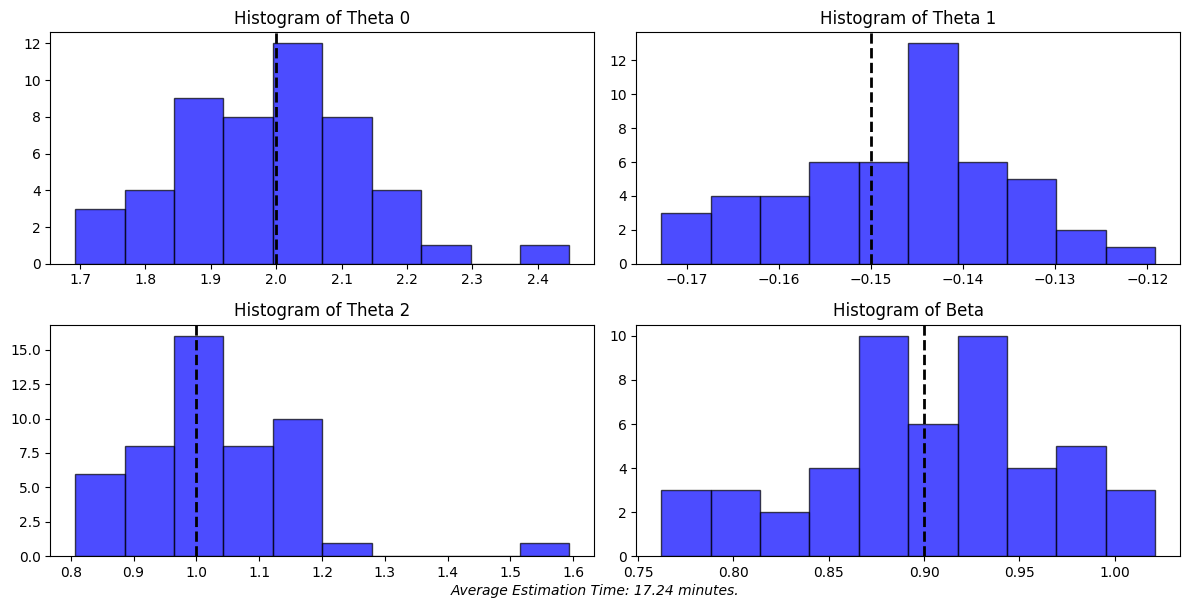

In [19]:
Bccp_df = pd.DataFrame(Bccp)
Bccp_df.columns = ["Theta 0", "Theta 1", "Theta 2", "Beta"]
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()
for i, col in enumerate(Bccp_df.columns):
    axes[i].hist(Bccp_df[col], bins=10, alpha=0.7, color='b', edgecolor='black')
    axes[i].axvline(alpha[i], color='black', linestyle='dashed', linewidth=2)
    axes[i].set_title(f'Histogram of {col}')

plt.figtext(0.5, 0, f"Average Estimation Time: {np.round(np.mean(Tccp) / 60, 2)} minutes.", 
            ha="center", fontsize=10, style="italic")

# Adjust layout
plt.tight_layout()
plt.show()